## NN time

### For this dataset we are going with a DNN


In [105]:
import torch
print(torch.cuda.is_available())

devices = [d for d in range(torch.cuda.device_count())]
device_names = [torch.cuda.get_device_name(d) for d in devices]
print(device_names)



False
[]


### Dataset prep

In [106]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

data = pd.read_csv('../data/final_dataset_1.csv')

X = data.drop(['price', 'density', 'yr_renovated',
              'sqm_basement', 'avg_degree','condition'], axis=1).values
# X = X.drop('density', axis=1).values
# X = X.drop('yr_renovated', axis=1).values
# X = X.drop('sqm_basement', axis=1).values
print(X.shape)
y = data['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

(21126, 13)


Defining the model and its losing and optimizing functions

In [107]:
import torch
import torch.nn as nn
import torch.optim as optim

# Definirea modelului DNN


class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        # Inițializarea layerelor
        # Primul layer primeste 13 caracteristici (după PCA)
        self.fc1 = nn.Linear(13, 128)
        self.fc2 = nn.Linear(128, 128)  # Al doilea layer
        self.fc3 = nn.Linear(128, 128)  # Al treilea layer
        self.fc4 = nn.Linear(128, 128)  # Al patrulea layer
        # Layerul de output cu o singură valoare (predictie)
        self.output = nn.Linear(128, 1)

    def forward(self, x):
        # Aplică ReLU pe fiecare layer, exceptând layerul de output
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.output(x)  # Nicio funcție de activare (liniară)
        return x
    

model = DNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim


class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        # Inițializarea layerelor
        self.fc1 = nn.Linear(13, 30)
        # Batch normalization pentru primul layer
        self.bn1 = nn.BatchNorm1d(30)
        self.fc2 = nn.Linear(30, 60)
        # Batch normalization pentru al doilea layer
        self.bn2 = nn.BatchNorm1d(60)
        self.fc3 = nn.Linear(60, 60)
        # Batch normalization pentru al treilea layer
        self.bn3 = nn.BatchNorm1d(60)
        self.fc4 = nn.Linear(60, 30)
        # Batch normalization pentru al patrulea layer
        self.bn4 = nn.BatchNorm1d(30)
        self.output = nn.Linear(30, 1)
        self.dropout = nn.Dropout(p=0.7)  # Dropout
        # Funcție de activare LeakyReLU
        self.activation = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.bn1(self.fc1(x))
        x = self.dropout(self.activation(x))
        x = self.bn2(self.fc2(x))
        x = self.dropout(self.activation(x))
        x = self.bn3(self.fc3(x))
        x = self.dropout(self.activation(x))
        x = self.bn4(self.fc4(x))
        x = self.dropout(self.activation(x))
        x = self.output(x)  # Layer de output fără funcție de activare (liniar)
        return x


# Inițializarea modelului, funcției de pierdere și optimizatorului
model = DNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Train

In [108]:
num_epochs = 300
model.train()  
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs, targets = inputs, targets

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/300], Loss: 35247640576.0000
Epoch [2/300], Loss: 5621941248.0000
Epoch [3/300], Loss: 7560015360.0000
Epoch [4/300], Loss: 14389262336.0000
Epoch [5/300], Loss: 66167029760.0000
Epoch [6/300], Loss: 8304008192.0000
Epoch [7/300], Loss: 70951264256.0000
Epoch [8/300], Loss: 52593713152.0000
Epoch [9/300], Loss: 73551478784.0000
Epoch [10/300], Loss: 7305989632.0000
Epoch [11/300], Loss: 19119640576.0000
Epoch [12/300], Loss: 1236159232.0000
Epoch [13/300], Loss: 26607988736.0000
Epoch [14/300], Loss: 6106862080.0000
Epoch [15/300], Loss: 22755917824.0000
Epoch [16/300], Loss: 89727746048.0000
Epoch [17/300], Loss: 5754351104.0000
Epoch [18/300], Loss: 9246089216.0000
Epoch [19/300], Loss: 8400501248.0000
Epoch [20/300], Loss: 8267377664.0000
Epoch [21/300], Loss: 19590746112.0000
Epoch [22/300], Loss: 19770843136.0000
Epoch [23/300], Loss: 16905680896.0000
Epoch [24/300], Loss: 9940597760.0000
Epoch [25/300], Loss: 6131036160.0000
Epoch [26/300], Loss: 38184361984.0000
Epoch [

Test

In [109]:
from sklearn.metrics import r2_score
# Set the model to evaluation mode
model.eval()

# Disable gradient calculation for evaluation
with torch.no_grad():
    inputs, targets = X_test, y_test
    predictions = model(inputs)

    # Calculating different metrics
    mse_loss = criterion(predictions, targets)  # MSE
    rmse_loss = torch.sqrt(mse_loss)            # RMSE
    mae_loss = torch.mean(torch.abs(predictions - targets))  # MAE
    r2 = r2_score(targets.cpu().numpy(), predictions.cpu().numpy())  # R2 score

    # Printing the metrics
    print(f'Test MSE Loss: {mse_loss.item():.4f}')
    print(f'Test RMSE Loss: {rmse_loss.item():.4f}')
    print(f'Test MAE Loss: {mae_loss.item():.4f}')
    print(f'R-squared Score: {r2:.4f}')


Test MSE Loss: 31196692480.0000
Test RMSE Loss: 176625.8594
Test MAE Loss: 111496.5156
R-squared Score: 0.7218


In [110]:
def regression_accuracy(model, data_loader, tolerance=0.1):
    total_samples = 0
    accurate_predictions = 0
    model.eval()

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs, targets
            outputs = model(inputs)
            # Calculăm acuratețea în funcție de toleranță
            accurate_predictions += ((outputs.squeeze() -
                                     targets).abs() / targets <= tolerance).sum().item()
            total_samples += targets.size(0)

    accuracy = (accurate_predictions / total_samples) * 100
    return accuracy


# Calculul acurateței
train_accuracy = regression_accuracy(model, train_loader, tolerance=0.1)
val_accuracy = regression_accuracy(model, train_loader, tolerance=0.1)
print(f"Train Accuracy (±10%): {train_accuracy:.2f}%")
print(f"Validation Accuracy (±10%): {val_accuracy:.2f}%")

Train Accuracy (±10%): 778.54%
Validation Accuracy (±10%): 771.70%


In [93]:
def calculate_accuracy(model, data_loader, threshold=0.10, epsilon=1e-8):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            # Adăugarea unei valori mici la numitor pentru a evita divizarea prin zero
            error_percentage = torch.abs(
                (outputs.flatten() - targets) / (targets + epsilon))
            # Verifică care predicții sunt sub pragul de eroare
            correct += torch.sum(error_percentage < threshold).item()
            total += targets.size(0)

    if total == 0:
        return 0  # Prevenirea divizării prin zero pentru set de date gol
    accuracy = 100 * correct / total
    return accuracy


accuracy = calculate_accuracy(model, test_loader)
print(f'Acuratețe: {accuracy}%')

Acuratețe: 218.6228111689541%


In [94]:
def calculate_accuracy(model, data_loader, absolute_threshold=0.5):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            absolute_errors = torch.abs(outputs.flatten() - targets)
            # Numără câte predicții au o eroare absolută sub un prag dat
            correct += torch.sum(absolute_errors < absolute_threshold).item()
            total += targets.size(0)

    if total == 0:
        return 0  # Prevenirea divizării prin zero pentru set de date gol
    accuracy = 100 * correct / total
    return accuracy


test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
# Setarea unui prag absolut pentru eroare
accuracy = calculate_accuracy(model, test_loader, absolute_threshold=0.5)
print(f'Acuratețe: {accuracy}%')

Acuratețe: 0.0%


---

# alta incercare nebuna
https://nbviewer.org/github/nadinezab/kc-house-prices-prediction/blob/master/kc-house-prices.ipynb#Simple-linear-regression

In [6]:
# Import libraries

import pandas as pd
import numpy as np

from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8-notebook')

from pathlib import Path
import pickle
import json


from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

import geopandas as gpd

from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure, ColumnDataSource
from bokeh.tile_providers import get_provider, CARTODBPOSITRON
from bokeh.palettes import Turbo256, RdYlGn
from bokeh.transform import linear_cmap,factor_cmap
from bokeh.layouts import row, column
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter


import folium 
from folium import plugins
from folium.plugins import HeatMap

import geopy.geocoders
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Bing

import reverse_geocoder as rg

import warnings
warnings.filterwarnings('ignore')

In [7]:
# Read data
kcdata = pd.read_csv('../data/final_dataset_1.csv')
kcdata.head()

,price,bedrooms,bathrooms,sqm_living,floors,condition,grade,yr_built,yr_renovated,avg_degree,degree_centrality,betweenness_centrality,closeness_centrality,density,sqm_above,sqm_basement,sqm_lot
0,204148.0,3,1.00,109.62554,1.0,3,7,1955,0,5.278075,0.004013,0.020863,0.054032,0.001765,109.62554,0.00000,524.901950
1,494960.0,3,2.25,238.76071,2.0,3,7,1951,1991,5.369496,0.002819,0.055100,0.039247,0.000946,201.59951,37.16120,672.803526
2,165600.0,2,1.00,71.53531,1.0,3,6,1933,0,5.141606,0.004383,0.031687,0.052035,0.001878,71.53531,0.00000,929.030000
3,555680.0,4,3.00,182.08988,1.0,5,7,1965,0,5.992501,0.004287,0.025728,0.041785,0.001606,97.54815,84.54173,464.515000
4,469200.0,3,2.00,156.07704,1.0,3,8,1987,0,5.440000,0.004804,0.055623,0.056724,0.002178,156.07704,0.00000,750.656240


In [8]:
len(kcdata)

21126

In [10]:
# Split features X and target y
X = kcdata.drop('price', axis=1)
y = kcdata['price']

In [11]:
# Train-test split (10% to test set)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

In [13]:
# A brief preview of train-test split
print(len(X_train), len(X_test), len(y_train), len(y_test))

19013 2113 19013 2113


In [14]:
# Set df as our training set, including features and target
df = pd.concat([X_train, y_train], axis=1)

In [15]:
df.head()

,bedrooms,bathrooms,sqm_living,floors,condition,grade,yr_built,yr_renovated,avg_degree,degree_centrality,betweenness_centrality,closeness_centrality,density,sqm_above,sqm_basement,sqm_lot,price
16841,3,2.50,160.72219,2.0,4,7,1985,0,4.767677,0.015190,0.217477,0.098799,0.006035,160.72219,0.00000,668.901600,230000.0
466,4,2.75,270.34773,1.0,3,8,1975,0,5.438512,0.000600,0.000000,0.031303,0.000816,165.36734,104.98039,989.416950,542800.0
10113,3,2.50,146.78674,2.0,3,7,2003,0,5.505798,0.005357,0.170882,0.066245,0.002458,146.78674,0.00000,201.599510,227976.0
19677,2,2.25,150.50286,2.0,3,8,2004,0,6.176757,0.004178,0.002292,0.058998,0.002151,143.07062,7.43224,171.034423,363400.0
3971,3,1.00,85.47076,1.0,4,7,1977,0,4.688172,0.086957,0.125179,0.164875,0.025479,85.47076,0.00000,1337.803200,195500.0


In [16]:
# Summary of data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19013 entries, 16841 to 15795
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bedrooms                19013 non-null  int64  
 1   bathrooms               19013 non-null  float64
 2   sqm_living              19013 non-null  float64
 3   floors                  19013 non-null  float64
 4   condition               19013 non-null  int64  
 5   grade                   19013 non-null  int64  
 6   yr_built                19013 non-null  int64  
 7   yr_renovated            19013 non-null  int64  
 8   avg_degree              19013 non-null  float64
 9   degree_centrality       19013 non-null  float64
 10  betweenness_centrality  19013 non-null  float64
 11  closeness_centrality    19013 non-null  float64
 12  density                 19013 non-null  float64
 13  sqm_above               19013 non-null  float64
 14  sqm_basement            19013 non-null 

In [17]:
# Investigate sqft_basement column
df['sqm_basement'].value_counts()

sqm_basement
0.000000      11491
65.032100       205
46.451500       195
55.741800       190
74.322400       187
              ...  
51.654068         1
47.008918         1
182.089880        1
231.328470        1
105.444905        1
Name: count, Length: 287, dtype: int64

In [19]:
# Get summary statistics for sqft_basement
df['sqm_basement'].describe()

count    19013.000000
mean        27.043334
std         40.783874
min          0.000000
25%          0.000000
50%          0.000000
75%         52.025680
max        447.792460
Name: sqm_basement, dtype: float64

In [20]:
df.isna().sum()

bedrooms                  0
bathrooms                 0
sqm_living                0
floors                    0
condition                 0
grade                     0
yr_built                  0
yr_renovated              0
avg_degree                0
degree_centrality         0
betweenness_centrality    0
closeness_centrality      0
density                   0
sqm_above                 0
sqm_basement              0
sqm_lot                   0
price                     0
dtype: int64

In [22]:
df.drop_duplicates(inplace=True)

In [24]:
# Cheking for duplicated rows
duplicates = df[df.duplicated()]
print(len(duplicates))
print("Numărul de rânduri după eliminarea duplicatelor:", len(df))

0
Numărul de rânduri după eliminarea duplicatelor: 18710


In [25]:
# Get summary statistics for yr_built
df['yr_built'].describe()

count    18710.000000
mean      1970.605131
std         29.547476
min       1900.000000
25%       1951.000000
50%       1974.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64

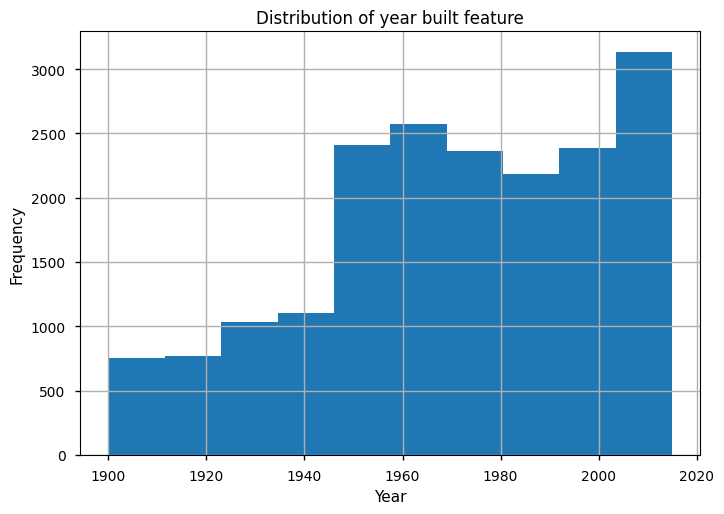

In [26]:
# Visualise yr_built distribution
df['yr_built'].hist()
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Distribution of year built feature')
plt.show()

In [27]:
# Define function to map yr_built into bins
def year_built(df):
    ''' Maps yr_built feature into categorical bins'''

    # Define bins based on statistics
    yr_built_bins = [1899, 1950, 1975, 1997, 2016]
    yr_built_labels = ['pre1950', '1950_to_1975',
                       '1975_to_1997', '1997_to_2015']

    # Map to bins using pd.cut()
    df['yr_built'] = pd.cut(
        df['yr_built'], bins=yr_built_bins, labels=yr_built_labels)

    return df

In [28]:
# Apply function to df
df = year_built(df)

In [31]:
# Define function has_basement
def has_basement(df):
    '''creates bool feature has_basement and drops original basement feature'''
    df['has_basement'] = df['sqm_basement'].map(lambda x: 1 if x > 0 else 0)
    df = df.drop('sqm_basement', axis=1)
    return df

In [32]:
# Apply function to df
df = has_basement(df)

In [33]:
# Get summary statistics for bathroom variable
df['bathrooms'].describe()

count    18710.000000
mean         2.107028
std          0.768084
min          0.000000
25%          1.500000
50%          2.250000
75%          2.500000
max          8.000000
Name: bathrooms, dtype: float64

In [34]:
# Get unique values
df['bathrooms'].unique()

array([2.5 , 2.75, 2.25, 1.  , 3.5 , 1.75, 2.  , 1.5 , 3.  , 4.  , 3.25,
       4.25, 3.75, 4.5 , 1.25, 6.75, 0.5 , 5.75, 0.75, 6.5 , 4.75, 0.  ,
       5.  , 5.5 , 5.25, 6.25, 6.  , 8.  , 7.5 , 7.75])

In [35]:
def round_bathrooms(df):
    '''Round bathroom feature and convert to int'''
    df['bathrooms'] = df['bathrooms'].map(lambda x: int(round(x, 0)))
    return df

In [36]:
# Apply function to df
df = round_bathrooms(df)

In [37]:
# Preview all changes
df.head()

,bedrooms,bathrooms,sqm_living,floors,condition,grade,yr_built,yr_renovated,avg_degree,degree_centrality,betweenness_centrality,closeness_centrality,density,sqm_above,sqm_lot,price,has_basement
16841,3,2,160.72219,2.0,4,7,1975_to_1997,0,4.767677,0.015190,0.217477,0.098799,0.006035,160.72219,668.901600,230000.0,0
466,4,3,270.34773,1.0,3,8,1950_to_1975,0,5.438512,0.000600,0.000000,0.031303,0.000816,165.36734,989.416950,542800.0,1
10113,3,2,146.78674,2.0,3,7,1997_to_2015,0,5.505798,0.005357,0.170882,0.066245,0.002458,146.78674,201.599510,227976.0,0
19677,2,2,150.50286,2.0,3,8,1997_to_2015,0,6.176757,0.004178,0.002292,0.058998,0.002151,143.07062,171.034423,363400.0,1
3971,3,1,85.47076,1.0,4,7,1975_to_1997,0,4.688172,0.086957,0.125179,0.164875,0.025479,85.47076,1337.803200,195500.0,0


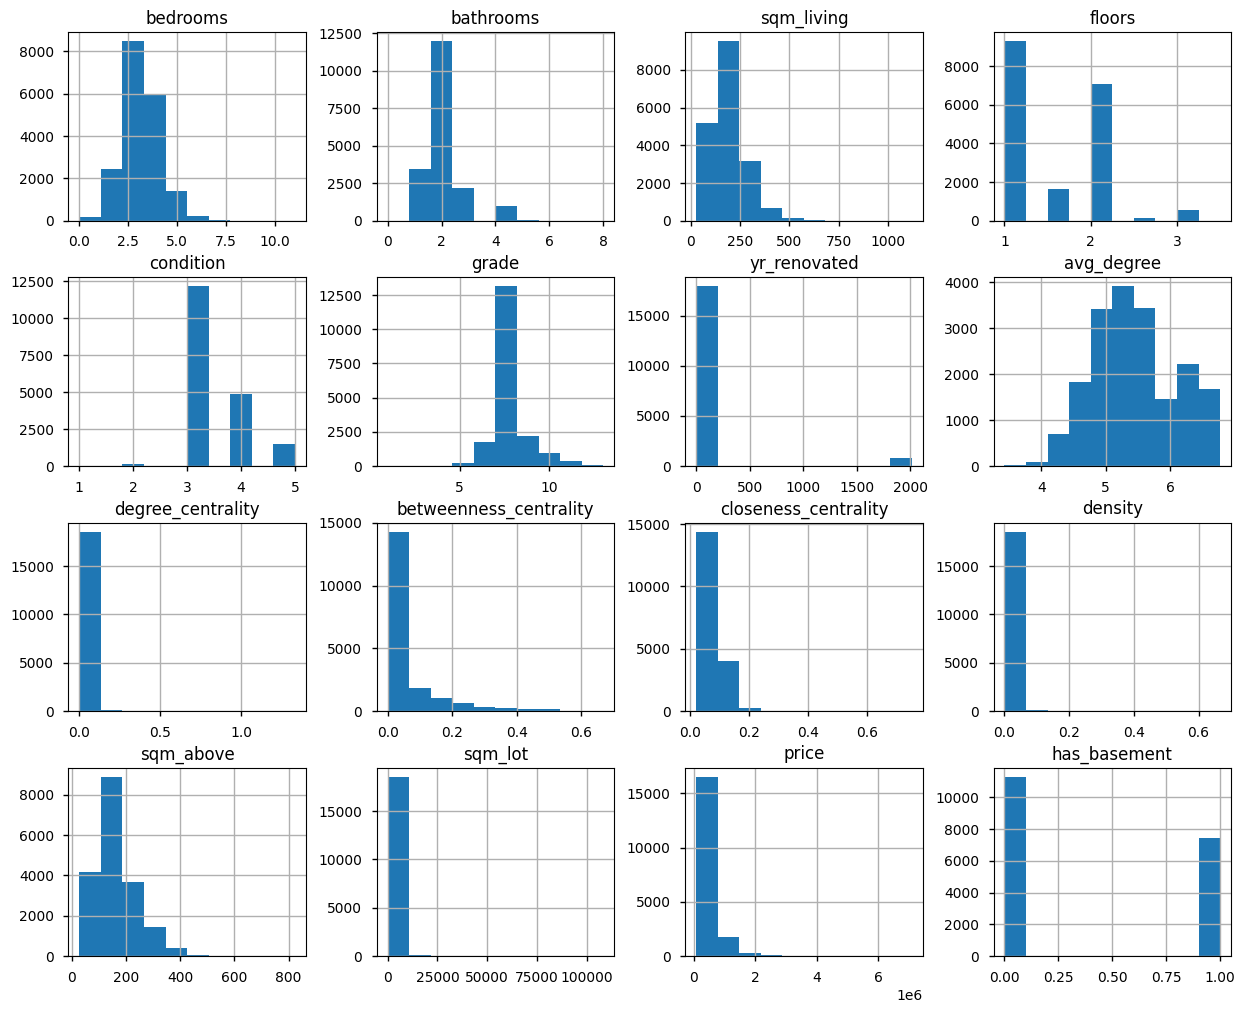

In [38]:
df.hist(figsize=(15, 12))
plt.show()

In [39]:
# Check initial size of df to see how much data we lost
originalsize = len(df)
originalsize

18710

In [48]:
# Define function to remove outliers
def remove_outliers(df):
    '''removes entries with z-score above 3 for specific columns'''
    variables = ['bedrooms', 'bathrooms', 'sqm_living', 'sqm_lot', 'sqm_above']

    for variable in variables:
        df = df[np.abs(df[variable]-df[variable].mean())
                <= (3*df[variable].std())]

    return df

In [49]:
# Apply function to df
df = remove_outliers(df)

In [50]:
# See size of df now
newsize = len(df)
newsize

17994

In [51]:
# Get % of data removed
round((originalsize-newsize)/originalsize*100, 2)

3.83

--- 
s-a dat un skip nebun
https://nbviewer.org/github/nadinezab/kc-house-prices-prediction/blob/master/kc-house-prices.ipynb#Simple-linear-regression:~:text=in%20section%209.-,Simple,-linear%20regression